# CrewLab Cropping Research

Currently we use a manual cropping that requires the user to correctly align the erg display in the middle of the camera in order to correctly analyze the display. To provide the user's with a better and more robust experience we want to automate the cropping by detecting the display.

## Assumptions
- Display is roughly centered
- Image isn't super blurry or washed out(if this is the case we can assume it will fail)
- Only consistent part of the display is the layout of the info on the display

## Ideas
- Use a simple edge detection algorithm and then a rectangle detection algorithm in order to crop on the largest rectangle
- Template Matching to generate some sort base representation of the display and then detect it
- CNN trained on classified images
- Apply threshold to emphasize the text on the display


## Pipeline Overview
1. Manipulate the base image to improve edge detection
2. Apply edge detection
3. Detect Rectangles
4. Find the correct one
5. Warp to adjust for distortions

In [1]:
# import the necessary packages
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.filters import threshold_local
import argparse
import imutils
from glob import glob

# Canny Edge Detection

The goal of this section is to determine the efficacy of Canny Edge Detection on erg displays. The hope is that the edges would generate a square around the outer edge of the display.

In [2]:
# Load Image
img = cv.imread('images/erg3.jpeg')

In [3]:
# generate graphs
def genGraphs(image,low,high):
    # Call Canny to get edges
    edges = cv.Canny(image,low,high,apertureSize=3)
    
    # plot edges next to original image
    plt.subplot(121),plt.imshow(image,cmap = 'gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(edges,cmap = 'gray')
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    plt.show()

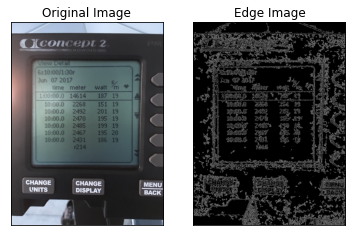

In [4]:
genGraphs(img,0,50)

In [5]:
# Manipulate Image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.medianBlur(gray, 5)
sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpen = cv.filter2D(blur, -1, sharpen_kernel)

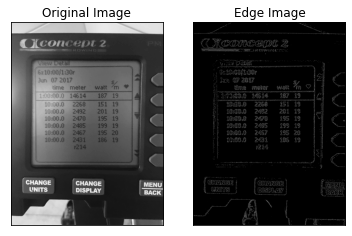

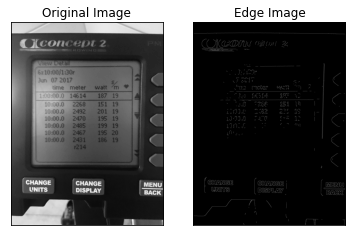

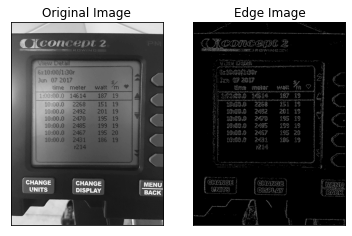

In [6]:
genGraphs(gray,60,70)
genGraphs(blur,100,150)
genGraphs(sharpen,100,150)

## Issues

- Low color contrast which leads to reduction in edges being detected
- Results varied a lot depending on the quality of the inputted image, specifically based upon the lighting

## Possible Directions
- Adjusting parameters until better results occur
- Look into other image manipulations that could increase the contrast between the monitor and the plastic that surrounds it

# Template Matching
This approach revovles around creating a template display that serves as a target to be found in the image. Sadly this doesn't work due to the fact that it doesn't adjust for any transformations of the template

In [7]:
template = cv.imread(r'images/erg-template-2.jpeg',0)
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

def cropTemplate(imgFile, method_index=4):
    img = cv.imread(imgFile,0)
    img2 = img.copy()
    w, h = template.shape[::-1]
    
    res = cv.matchTemplate(img,template,eval(methods[method_index]))
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print("Method:  " , methods[method_index])
    print("min_val: " , min_val)
    print("max_val: " , max_val)
    print("min_loc: " , min_loc)
    print("max_loc: " , max_loc)
    print(" ")
    if eval(methods[method_index]) in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    box = img[top_left[1]:top_left[1]+h,0:bottom_right[1]+w]
    
    # display result
    # plot edges next to original image
    plt.imshow(box,cmap='gray', vmin=0, vmax=255)
    plt.show()

Method:   cv.TM_SQDIFF
min_val:  103643720.0
max_val:  7618636288.0
min_loc:  (255, 570)
max_loc:  (0, 1229)
 


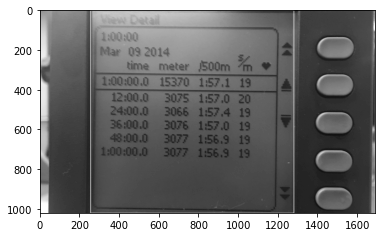

In [8]:
cropTemplate('images/erg0.jpeg')

Method:   cv.TM_SQDIFF
min_val:  1437698944.0
max_val:  6505308160.0
min_loc:  (459, 655)
max_loc:  (208, 0)
 


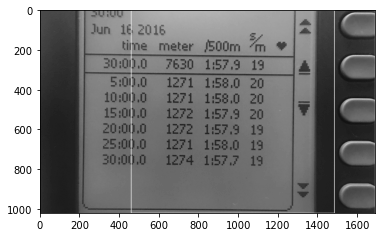

In [9]:
cropTemplate('images/erg2.jpeg')

Method:   cv.TM_SQDIFF
min_val:  1059997312.0
max_val:  5019218944.0
min_loc:  (1, 727)
max_loc:  (0, 1229)
 


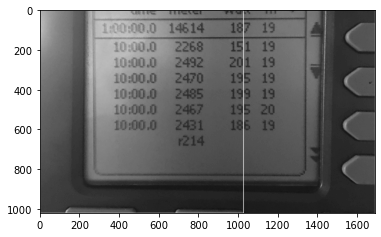

In [10]:
cropTemplate('images/erg3.jpeg')

Method:   cv.TM_SQDIFF
min_val:  1061598976.0
max_val:  5854496256.0
min_loc:  (437, 654)
max_loc:  (288, 0)
 


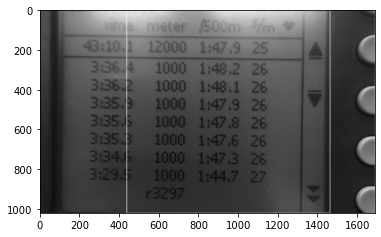

In [11]:
cropTemplate('images/erg4.jpeg')

## Issues

- Doesn't account for transformations in the template(for instance if it was rotated or scaled up)

## Possible Directions
- None that I can think of

# Square Detector using Canny

In [12]:
# Helper functions
def angle_cos(p0, p1, p2):
    """
        Calculates the cosine
    """
    d1, d2 = (p0-p1).astype(float), (p2-p1).astype(float)
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def area(XY, n): 
    """
        Calculates the area of a polygon with n vertices using the shoelace formula
    """
    area = 0.0 
    j = n - 1 # j is previous vertex to i 
    for i in range(0,n): 
        area += (XY[j][0] + XY[i][0]) * (XY[j][1] - XY[i][1]) 
        j = i
    return int(abs(area / 2.0)) 
    
def find_largest_square(sqrs):
    """
        Finds the larges square based upon area
    """
    res = sqrs[0]
    for i in sqrs:
        if area(i,4)>area(res,4):
            res=i
    return res

In [13]:
def find_squares(img):
    # smooth the image
    img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
    
    # split the images channels
    for gray in cv.split(img):
        # loop over thresholds
        for thrs in range(0, 255, 26):
            # set the thre
            if thrs == 0:
                bins = cv.Canny(gray, 0, 50, apertureSize=5)
                bins = cv.dilate(bins, None)
            else:     
                _retval, bins = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
                
            contours, _hierarchy = cv.findContours(bins, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                cnt_len = cv.arcLength(cnt, True)
                cnt = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
                if len(cnt) == 4 and cv.contourArea(cnt) > 1000 and cv.isContourConvex(cnt):
                    cnt = cnt.reshape(-1, 2)
                    max_cos = np.max([angle_cos( cnt[i], cnt[(i+1) % 4], cnt[(i+2) % 4] ) for i in range(4)])
                    if max_cos < 0.1:
                        squares.append(cnt)
    return squares

In [14]:
# Run on all images
for fn in glob('images/erg?.jpeg'):
    img = cv.imread(fn)

    # create 3 versions of the image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv.filter2D(blur, -1, sharpen_kernel)

    image = sharpen
    squares = find_squares(image)
    final = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    
    # check for squares and then draw them
    if len(squares)>0:
        large = find_largest_square(squares)
        cv.drawContours( final, squares, -1, (0, 255, 0), 3 )
        cv.drawContours( final, [large], -1, (0, 0, 255), 3 )
    else:
        cv.drawContours( final, squares, -1, (0, 255, 0), 3 )

    cv.namedWindow('squares',cv.WINDOW_NORMAL)
    cv.resizeWindow('squares', 600,600)

    cv.imshow('squares', final)
    ch = cv.waitKey()
    if ch == 27:
        break
cv.destroyAllWindows()

## Pipeline attempt
This is a 3 stage pipeline:
1. Detect Edges
2. Find Contours
3. Transform image

Example for scanning a piece of paper

In [15]:
def order_points(pts):
    """
        Order's coordinates in a clockwise manner
        [top-left, top-right, bottom-right, bottom-left]
    """
    rect = np.zeros((4, 2), dtype = "float32")
    
    # top-left = smallest sum(x,y)
    # bottom-right = largest sum(x,y)
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # top-right = smallest difference between x and y
    # bottom-left = largest difference between x and y
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    """
        Convert 4 points into a rectangle to correct distordion caused by perspective
    """
    # order the points
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # compute the width of the new image(max width(x coord) either (tl, tr) or (bl, br)
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # compute the height of the new image(max height(y coord) either (tl,bl) or (tr,br))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # mapping from rect onto new plan (ie tl = (0,0) and so on)
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

In [16]:
# load the image and compute the ratio of the old height to the new height, clone it, and resize it
image = cv.imread('images/erg2.jpeg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)

# convert the image to grayscale, blur it, and find edges in the image
gray = cv.GaussianBlur(image, (5, 5), 0)
edged = cv.Canny(gray, 75, 200)

# show the original image and the edge detected image
cv.imshow("Image", imutils.resize(image, height = 650))
cv.imshow("Edged", imutils.resize(edged, height = 650))
cv.waitKey(0)
cv.destroyAllWindows()

# find the contours in the edged image, keeping only the largest ones, and initialize the screen contour
cnts = cv.findContours(edged.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:5]

# loop over the contours
for c in cnts:
    # approximate the contour
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.02 * peri, True)
    # take the first contour that has 4 points
    if len(approx) == 4:
        screenCnt = approx
        break
        
# show the contour
cv.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv.imshow("Outline", image)
cv.waitKey(0)
cv.destroyAllWindows()

# apply the four point transform to obtain a top-down view of the original image
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)

# convert the warped image to grayscale, then threshold it to give it that 'black and white'
warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
T = threshold_local(warped, 11, offset = 10, method = "gaussian")
warped = (warped > T).astype("uint8") * 255

# show the original and scanned images
cv.imshow("Original", imutils.resize(orig, height = 650))
cv.imshow("Scanned", imutils.resize(warped, height = 650))
cv.waitKey(0)
cv.destroyAllWindows()

## Image Threshold
Attempt to distinguish the text on the display from the image. Since the contents of the display are the only consistent part, here I attempted to use the text on the display to detect the display.

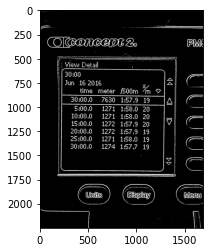

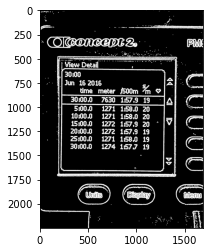

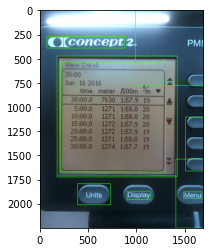

In [17]:
image = cv.imread('images/erg2.jpeg')
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (9,9), 0)

# apply  threshold 
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,2)

# dilate to combine adjacent text contours
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
dilate = cv.dilate(thresh, kernel, iterations=2)

# Find contours, highlight text areas, and extract ROIs
cnts = cv.findContours(dilate, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    area = cv.contourArea(c)
    if area > 10000:
        x,y,w,h = cv.boundingRect(c)
        cv.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)

# display result
plt.imshow(thresh,cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(dilate,cmap='gray', vmin=0, vmax=255)
plt.show()
plt.imshow(image, vmin=0, vmax=255)
plt.show()

cv.namedWindow("Threshold",cv.WINDOW_NORMAL)
cv.resizeWindow("Threshold", 600,600)
cv.imshow('Threshold', thresh)

cv.namedWindow("Dilated",cv.WINDOW_NORMAL)
cv.resizeWindow("Dilated", 600,600)
cv.imshow('Dilated', dilate)

cv.namedWindow("Image",cv.WINDOW_NORMAL)
cv.resizeWindow("Image", 600,600)
cv.imshow('Image', image)

cv.waitKey(0)
cv.destroyAllWindows()

### Possible Directions
- Potentially pass the dilated version into Canny to find the internal box
- Adjust parameters and test repeatibility
- CNN could be fun
